In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt

# NB!!! For alle dyp

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path = 's3://velocity-u.zarr/'
remote_files = fsg.glob(data_path)

store = s3fs.S3Map(root=data_path, s3=fsg, check=False)
du = xr.open_zarr(store=store, consolidated=True)
du = du.rename({'depthu' : 'depth'})
du 

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depth: 75, time_counter: 73, x: 1580, y: 1801)
Coordinates:
  * depth                 (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat               (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    time_centered         (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter          (time_counter) object 2000-01-03 12:00:00 ... 2000-...
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthu_bounds         (time_counter, depth, axis_nbounds) float32 dask.array<chunksize=(1, 75, 2), meta=np.ndarray>
    sozotaux              (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(73, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(73, 2), meta=np.ndarray>
    utau_atmoce           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    utau_iceoce           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    uwspd10               (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    vozocrtx              (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 1801, 1580), meta=np.ndarray>
Attributes:
    CASE:              REF08
    CONFIG:            CREG12.L75
    Conventions:       CF-1.5
    description:       ocean U grid variables
    name:              /scratch/cnt0028/lpo7420/talandic/CREG12.L75-REF08-XIO...
    output_frequency:  5d
    production:        An IPSL model
    start_date:        19790101
    timeStamp:         2020-May-14 08:39:48 CEST
    title:             ocean U grid variables

In [5]:
u = du.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
mbathy = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

## Punkt 1

In [6]:
x_p = 500
y_p = 500
d = mbathy.isel(x=x_p, y=y_p).values

In [8]:
dyp = u.isel(x=x_p, y=y_p, depth = slice(0,d-1))
print(dyp.depth.values)
dyp.shape

[5.0576001e-01 1.5558553e+00 2.6676817e+00 3.8562799e+00 5.1403613e+00
 6.5430336e+00 8.0925188e+00 9.8227501e+00 1.1773680e+01 1.3991038e+01
 1.6525322e+01 1.9429802e+01 2.2757616e+01 2.6558300e+01 3.0874561e+01
 3.5740204e+01 4.1180023e+01 4.7211895e+01 5.3850636e+01 6.1112839e+01
 6.9021683e+01 7.7611160e+01 8.6929428e+01 9.7041313e+01 1.0803028e+02
 1.2000000e+02 1.3307582e+02 1.4740625e+02 1.6316446e+02 1.8054993e+02
 1.9978996e+02 2.2114117e+02 2.4489062e+02 2.7135638e+02 3.0088751e+02
 3.3386282e+02 3.7068848e+02 4.1179385e+02 4.5762561e+02 5.0863989e+02
 5.6529230e+02 6.2802600e+02 6.9725867e+02 7.7336829e+02 8.5667896e+02
 9.4744788e+02 1.0458542e+03 1.1519912e+03 1.2658615e+03 1.3873770e+03
 1.5163636e+03 1.6525685e+03 1.7956708e+03 1.9452955e+03 2.1010266e+03
 2.2624216e+03 2.4290251e+03 2.6003804e+03 2.7760393e+03 2.9555703e+03]


(73, 60)

In [9]:
cov_p = np.cov(dyp.T, bias=True) # .T for at den skal velge hver rekke (aka 5) som varaibler
values, vectors = np.linalg.eig(cov_p)
order = values.argsort()[::-1]
values, vectors = values[order], vectors[:, order] 

## Punkt 2

In [11]:
x_p2 = 660
y_p2 = 790 

'Finding the level the given location dosent have values for anymore'

mbathy = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))
d2 = mbathy.isel(x=x_p2, y=y_p2).values

'Lager indexer for å lage covmatrise for, henter fra topp, dyp og i mellom'

dyp2 = u.isel(x=x_p2, y=y_p2, depth = slice(0,d2-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
print(dyp2.shape)

cov_p2 = np.cov(dyp2.T, bias=True) # uten .T ble den en 73x73 matrise 
values2, vectors2 = np.linalg.eig(cov_p2)
order2 = values2.argsort()[::-1]
values2, vectors2 = values2[order2], vectors2[:, order2]
 

(73, 12)


# punkt 3

In [12]:
x_p3 = 650
y_p3 = 300 

'Finding the level the given location dosent have values for anymore'

d3 = mbathy.isel(x=x_p3, y=y_p3).values

dyp3 = u.isel(x=x_p3, y=y_p3, depth = slice(0,d3-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
print(dyp3.shape)

cov_p3 = np.cov(dyp3.T, bias=True) # uten .T ble den en 73x73 matrise 
values3, vectors3 = np.linalg.eig(cov_p3)
order3 = values3.argsort()[::-1]
values3, vectors3 = values3[order3], vectors3[:, order3] 

(73, 65)


## Punkt 4

In [13]:
x_p4 = 870
y_p4 = 600 

'Finding the level the given location dosent have values for anymore'

d4 = mbathy.isel(x=x_p4, y=y_p4).values

dyp4 = u.isel(x=x_p4, y=y_p4, depth = slice(0,d4-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter

cov_p4 = np.cov(dyp4.T, bias=True) # uten .T ble den en 73x73 matrise 
values4, vectors4 = np.linalg.eig(cov_p4)
order4 = values4.argsort()[::-1]
values4, vectors4 = values4[order4], vectors4[:, order4]

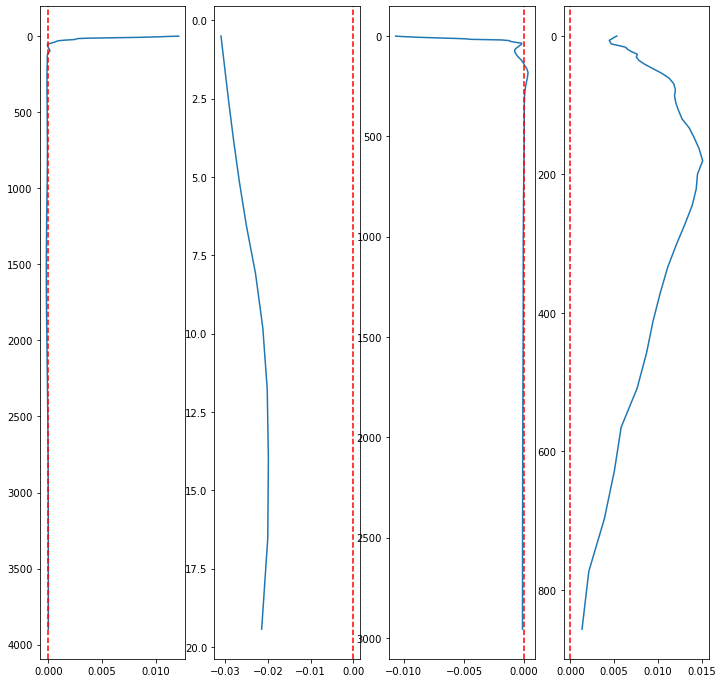

In [14]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1,4,figsize = (12,12))

ax1.plot(vectors3[:,0]*np.sqrt(values3[0]),dyp3.depth)
ax1.axvline(0, color='r', linestyle = '--')
ax1.invert_yaxis()

ax2.plot(vectors2[:,0]*np.sqrt(values2[0]),dyp2.depth)
ax2.axvline(0, color='r', linestyle = '--')
ax2.invert_yaxis()

ax3.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth)
ax3.axvline(0, color='r', linestyle = '--')
ax3.invert_yaxis()

ax4.plot(vectors4[:,0]*np.sqrt(values4[0]),dyp4.depth)
ax4.axvline(0, color='r', linestyle = '--')
ax4.invert_yaxis()

 BC modes with acctual stratification have zerocrossings higher in the water column with large ampiltude near surface. The BC modes differ in the upper 10m, where the modes tends to flatten out, indicating weak stratification, thus the shear in the mixed layer is more BT than BC
 
 --> fra joes copendium

# skipping the first 20m 

In [51]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors

In [41]:
punkt_list = [(500,500), (660,790), (650,300), (870,600), (820,200), (520,350)]

In [44]:
x=500
y=500
d = mbathy.isel(x=x, y=y).values
dyp = u.isel(x=x, y=y, depth = slice(15,d-1))
dyp

<xarray.DataArray 'vozocrtx' (time_counter: 73, depth: 45)>
dask.array<getitem, shape=(73, 45), dtype=float32, chunksize=(1, 45), chunktype=numpy.ndarray>
Coordinates:
  * depth          (depth) float32 35.74 41.18 47.21 ... 2.776e+03 2.956e+03
    nav_lat        float32 dask.array<chunksize=(), meta=np.ndarray>
    nav_lon        float32 dask.array<chunksize=(), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [ ]:
fig, axes = plt.subplots(1,6,figsize = (12,17))
axes = ['ax1','ax2','ax3','ax4','ax5','ax6']
for p in range(len(punkt_list)):
    pp = punkt_list[p]
    
    print(pp[0], pp[1])
    
    values, vectors = PCz(pp[0],pp[1])
    
    axes[p].plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth, 'r')
    axes[p].plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth, 'b')
    axes[p].plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth, 'g')
    axes[p].axvline(0, color='r', linestyle = '--')
    axes[p].invert_yaxis()


500 500
